# Отток клиентов 

В датасете предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. Целью данной работы является построение модели, прогнозирующей отток клиентов банка

## 1. Подготовка данных

##  Содержание

1. [Подготовка данных](#1.-Подготовка-данных)
2. [Исследование задачи](#2.-Исследование-задачи)
3. [Борьба с дисбалансом](#3.-Борьба-с-дисбаланасом)
4. [Тестирование модели](#4.-Тестирование-модели)

### Описание целей и задачи проекта

Целью данной работы является прогнозирование оттока клиентов банка на основании личных данных и информации о пользовании услугами банка. С учетом дисбаланса целевой переменной для оценки качества была использована метрика f1. В работе дана оценка трех базовых алгоритмов - Логистической регрессии, Решающего дерева и Случайного леса на несбалансированной выборке, а также представлены способы улучшения качества с учетом дисбаланса классов.

### План работы 

* EDA
* Проверка качества и подбор гиперпараметров для базовых алгоритмов на несбалансированной выборке
* Улучшение качество моделей с учетом дисбаланса классов (class_weight, Upsampling of minority class, Downsampling of majority class, Изменение порога классификации)
* Провенка качества на тестовой выборке

### Описание данных

* **RowNumber** - индекс строки в данных
* **CustomerId** - уникальный идентификатор клиента
* **Surname** - фамилия
* **CreditScore** - кредитный рейтинг
* **Geography** — страна проживания
* **Gender** — пол
* **Age** — возраст
* **Tenure** — сколько лет человек является клиентом банка
* **Balance** — баланс на счёте
* **NumOfProducts** — количество продуктов банка, используемых клиентом
* **HasCrCard** — наличие кредитной карты
* **IsActiveMember** — активность клиента
* **EstimatedSalary** — предполагаемая зарплата
* **Exited** — факт ухода клиента


In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random

from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve 

In [2]:
pth1 = '/datasets/Churn.csv'
pth2 = '.\Churn.csv'
if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong')
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
#приведем названия столбцов к snake_case
df.columns = df.columns.str.replace(r"([A-Z])", r" \1", regex=True).str.lower().str.replace(' ', '_').str[1:]

In [5]:
df.head(3)

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1


In [6]:
# проверим наличие дубликатов
df.duplicated().sum()

0

In [7]:
df.isnull().sum()

row_number            0
customer_id           0
surname               0
credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

In [8]:
# удалим из датасета столбцы, которые не пригодятся для анализа
df.drop(['row_number', 'customer_id', 'surname'], axis='columns',inplace=True)

In [9]:
df.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [10]:
# в столбце Tenure большое количество пропусков, посмотрим как в нем распределены значения
df['tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

In [11]:
df['tenure'].isnull().sum()

909

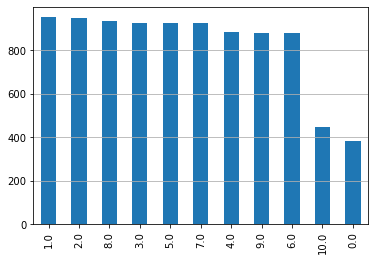

In [12]:
df['tenure'].value_counts(sort = True).plot.bar(figsize=(6, 4))
plt.grid(axis='y')

Заменим пропущенные значения случйными числами от 1 до 10

In [13]:
random.seed(11)

In [14]:
df['tenure'] = df['tenure'].fillna(df['tenure'].apply(lambda x: random.randrange(0, 11, 1))).astype('int') 

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int32  
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(2), int32(1), int64(6), object(2)
memory usage: 820.4+ KB


In [16]:
df.describe()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.985600,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.921857,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


array([[<AxesSubplot:title={'center':'credit_score'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'tenure'}>],
       [<AxesSubplot:title={'center':'balance'}>,
        <AxesSubplot:title={'center':'num_of_products'}>,
        <AxesSubplot:title={'center':'has_cr_card'}>],
       [<AxesSubplot:title={'center':'is_active_member'}>,
        <AxesSubplot:title={'center':'estimated_salary'}>,
        <AxesSubplot:title={'center':'exited'}>]], dtype=object)

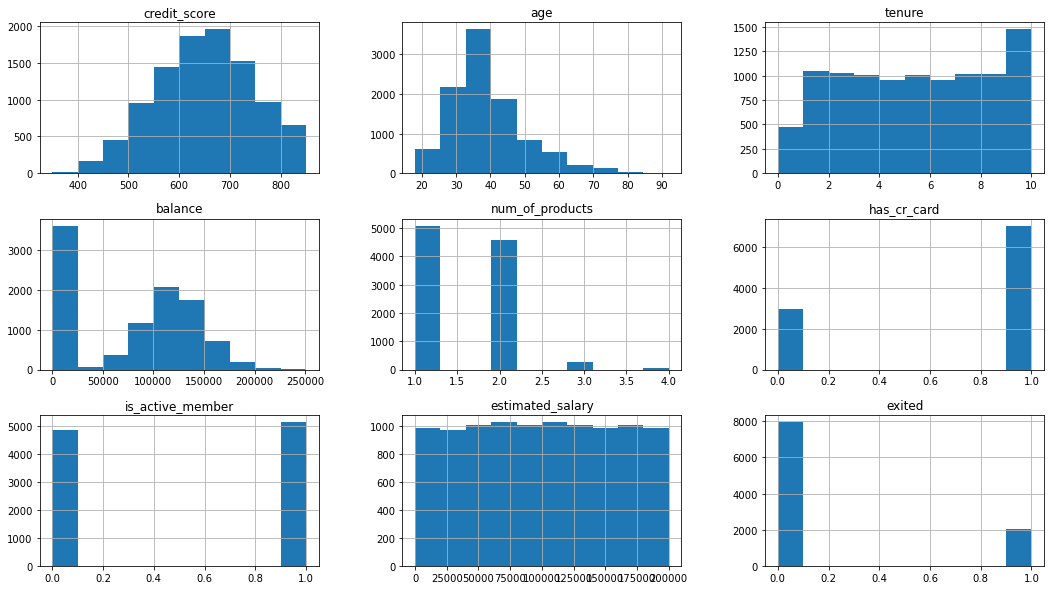

In [17]:
# посмотрим на распределения признаков
df.hist(figsize=(18, 10))

**Посмотрим распределение целевой переменной**

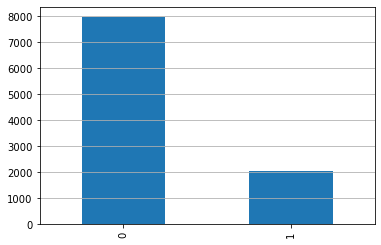

In [18]:
df['exited'].value_counts().plot.bar(figsize=(6, 4))
plt.grid(axis='y')

In [19]:
df['exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

**В представленном датасете наблюдается явный дисбаланс классов. Здесь же можно представить наш baseline качества, с которым можно будет сравнивать результаты работы модели. Если у нас 80% одного класса и 20% другого, то даже если наша модель будет предсказывать только No, то accuracy будет равна, в среднем, 80%.
Для начала попробуем поработать с этими данными и посмотреь какое качество даст модель. Следующим шагом учтем дисбаланс классов и посмотрим получившиеся метрики.** 

In [20]:
#уберем из датасете целевую переменную и закодируем категориальные признаки техникой OHE
target = df['exited']
data_ohe = pd.get_dummies(df, drop_first=True)
features = data_ohe.drop('exited', axis=1)

Разобьем данные на тестовую, тренировочную и валидационную выборки. Поскольку в датасете присутствует дисбаланс классов, укажем параметр stratify, чтобы соблюсти баланс классов в выборках.

In [21]:
# для начала выделим 60% данных для тренировочной выбрки
features_train, features_other, target_train, target_other = train_test_split(features,
                                                    target,
                                                    test_size=0.40,
                                                    shuffle=True,
                                                    stratify=target,
                                                    random_state=48)

In [22]:
print('features_train dimension= ', features_train.shape)
print('features_other dimension= ', features_other.shape)
print('y_train dimension= ', target_train.shape)
print('y_other dimension= ', target_other.shape)

features_train dimension=  (6000, 11)
features_other dimension=  (4000, 11)
y_train dimension=  (6000,)
y_other dimension=  (4000,)


In [23]:
#теперь разделим оставшиеся данные пополам на тетовую и валидационную выборки (таким образом получим соотношение 60% 20% 20%)
features_val, features_test, target_val, target_test = train_test_split(features_other,
                                                target_other,
                                                test_size=0.50,
                                                shuffle=True,
                                                stratify=target_other,
                                                random_state=48)

In [24]:
print('features_val dimension= ', features_val.shape)
print('features_test dimension= ', features_test.shape)
print('y_val dimension= ', target_val.shape)
print('y_test dimension= ', target_test.shape)

features_val dimension=  (2000, 11)
features_test dimension=  (2000, 11)
y_val dimension=  (2000,)
y_test dimension=  (2000,)


## 2. Исследование задачи

Предварительно отмасштабируем данные скеллером 

In [25]:
df = df.drop('exited', axis=1)

In [26]:
num_col = [col for col in df.columns if df[col].dtype != 'object']

scaler = MinMaxScaler()
features_train[num_col] = scaler.fit_transform(features_train[num_col])
features_val[num_col] = scaler.transform(features_val[num_col])
features_test[num_col] = scaler.transform(features_test[num_col])

<ipython-input-26-83f9eb7f1c20>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[num_col] = scaler.fit_transform(features_train[num_col])
C:\Users\Lenin\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-26-83f9eb7f1c20>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

Обучим на наших данных несколько различных моделей, подберем оптимальные гиперпараметры и сравним значения метрики f1.

### LogisticRegression

In [27]:
best_model = None
best_result = 0
for p in ['l1', 'l2']:
    for c in np.arange(0.001, 10.0, 1):
        model = LogisticRegression(random_state=12345, penalty= p, C = c, max_iter=10000, solver='liblinear') 
        model.fit(features_train, target_train) 
        result = f1_score(target_val, model.predict(features_val)) 
        if result > best_result:
            best_model = model 
            best_result = result 

print("f1 наилучшей модели на валидационной выборке:", best_result)
print("Лучшие параметры", best_model)

f1 наилучшей модели на валидационной выборке: 0.3217550274223035
Лучшие параметры LogisticRegression(C=1.001, max_iter=10000, random_state=12345,
                   solver='liblinear')


### Decision Tree

In [28]:
best_model = None
best_result = 0
best_crit = None

for crit in ['gini', 'entropy']:
    for depth in range(1, 15):
        model = DecisionTreeClassifier(random_state=12345, criterion = crit, max_depth=depth) 
        model.fit(features_train, target_train) 
        result = f1_score(target_val, model.predict(features_val)) 
        if result > best_result:
            best_model = model 
            best_result = result 
            best_crit = crit

print("f1 наилучшей модели на валидационной выборке:", best_result)
print("Лучшие параметры", best_model, crit)

f1 наилучшей модели на валидационной выборке: 0.5982658959537572
Лучшие параметры DecisionTreeClassifier(max_depth=5, random_state=12345) entropy


### RandomForestClassifier

In [29]:
%%time
best_model = None
best_result = 0

for max_dep in [1, 5, 10, 15, 20]:
    for est in [50, 75, 100, 125, 150, 200, 250, 300, 400]:
        model = RandomForestClassifier(random_state=12345, max_depth=max_dep, n_estimators = est) 
        model.fit(features_train, target_train) 
        result = f1_score(target_val, model.predict(features_val)) 
        if result > best_result:
            best_model = model 
            best_result = result 

print("f1 наилучшей модели на валидационной выборке:", best_result)
print("Лучшие параметры", best_model)

f1 наилучшей модели на валидационной выборке: 0.599388379204893
Лучшие параметры RandomForestClassifier(max_depth=20, n_estimators=250, random_state=12345)
Wall time: 53.4 s


**Наибольшее значение метрики f1 (0.6) показала модель RandomForestClassifier(max_depth=20, n_estimators=250, random_state=12345). Попробуем улучшить качество, учитывая дисбаланс классов.**

## 3. Борьба с дисбалансом

* ### class_weight

Изменим веса классов с помощью class_weight='balanced' и снова подберем гиперпараметры

**LogisticRegression**

In [30]:
best_model = None
best_result = 0
for p in ['l1', 'l2']:
    for c in np.arange(0.001, 10.0, 0.5):
        model = LogisticRegression(random_state=12345, penalty= p, C = c, max_iter=10000, solver='liblinear', class_weight='balanced') 
        model.fit(features_train, target_train) 
        result = f1_score(target_val, model.predict(features_val)) 
        if result > best_result:
            best_model = model 
            best_result = result 

print("f1 наилучшей модели на валидационной выборке:", best_result)
print("Лучшие параметры", best_model)

f1 наилучшей модели на валидационной выборке: 0.5083260297984225
Лучшие параметры LogisticRegression(C=3.001, class_weight='balanced', max_iter=10000,
                   random_state=12345, solver='liblinear')


С помощью этого метода f1 значительно увеличилась - на 0.19.

**DecisionTreeClassifier**

In [31]:
best_model = None
best_result = 0
best_crit = None

for crit in ['gini', 'entropy']:
    for depth in range(1, 15):
        model = DecisionTreeClassifier(random_state=12345, criterion = crit, max_depth=depth, class_weight='balanced') 
        model.fit(features_train, target_train) 
        result = f1_score(target_val, model.predict(features_val)) 
        if result > best_result:
            best_model = model 
            best_result = result 
            best_crit = crit

print("f1 наилучшей модели на валидационной выборке:", best_result)
print("Лучшие параметры", best_model, crit)

f1 наилучшей модели на валидационной выборке: 0.5784418356456776
Лучшие параметры DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=12345) entropy


при добавлении баланса классов значение f1 уменьшилось на 0.01

In [32]:
%%time
best_model = None
best_result = 0
positive_weight = sum(target_train == 1) / sum(target_train == 0)
for max_dep in [1, 5, 10, 15, 20]:
    for est in [10, 20, 50, 75, 100, 125, 150, 200, 250, 300, 400]:
        model = RandomForestClassifier(random_state=12345, max_depth=max_dep, n_estimators = est, class_weight = {0 : 1, 1 : positive_weight}) 
        model.fit(features_train, target_train) 
        result = f1_score(target_val, model.predict(features_val)) 
        if result > best_result:
            best_model = model 
            best_result = result 

print("f1 наилучшей модели на валидационной выборке:", best_result)
print("Лучшие параметры", best_model)

f1 наилучшей модели на валидационной выборке: 0.5937961595273265
Лучшие параметры RandomForestClassifier(class_weight={0: 1, 1: 0.25575554625366265},
                       max_depth=20, n_estimators=125, random_state=12345)
Wall time: 57.6 s


с использование баланса весом класса значение f1 модели RandomForestClassifier не изменилось

* ### Upsampling of minority class

напишем функцию, которая копирует объекты минорного класса

In [33]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled


In [34]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [35]:
scaler = MinMaxScaler()
features_upsampled[num_col] = scaler.fit_transform(features_upsampled[num_col])
features_val[num_col] = scaler.transform(features_val[num_col])
features_test[num_col] = scaler.transform(features_test[num_col])

<ipython-input-35-83a1d9b7694b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_val[num_col] = scaler.transform(features_val[num_col])
C:\Users\Lenin\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-35-83a1d9b7694b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

**LogisticRegression**

In [36]:
best_model = None
best_result = 0
for p in ['l1', 'l2']:
    for c in np.arange(0.001, 10.0, 0.5):
        model = LogisticRegression(random_state=12345, penalty= p, C = c, max_iter=10000, solver='liblinear') 
        model.fit(features_upsampled, target_upsampled) 
        result = f1_score(target_val, model.predict(features_val)) 
        if result > best_result:
            best_model = model 
            best_result = result 

print("f1 наилучшей модели на валидационной выборке:", best_result)
print("Лучшие параметры", best_model)

f1 наилучшей модели на валидационной выборке: 0.5043177892918825
Лучшие параметры LogisticRegression(C=0.501, max_iter=10000, penalty='l1', random_state=12345,
                   solver='liblinear')


Для логистической регресси за счет данного метода значение f1 увеличилось на 0.18. 

**DecisionTreeClassifier**

In [37]:
best_model = None
best_result = 0
best_crit = None

for crit in ['gini', 'entropy']:
    for depth in range(1, 15):
        model = DecisionTreeClassifier(random_state=12345, criterion = crit, max_depth=depth) 
        model.fit(features_upsampled, target_upsampled) 
        result = f1_score(target_val, model.predict(features_val)) 
        if result > best_result:
            best_model = model 
            best_result = result 
            best_crit = crit

print("f1 наилучшей модели на валидационной выборке:", best_result)
print("Лучшие параметры", best_model, crit)

f1 наилучшей модели на валидационной выборке: 0.5778251599147121
Лучшие параметры DecisionTreeClassifier(max_depth=8, random_state=12345) entropy


значение f1 уменьшилось на 0.02

**RandomForestClassifier**

In [38]:
%%time
best_model = None
best_result = 0
for max_dep in [1, 5, 10, 15, 20]:
    for est in [10, 20, 50, 75, 100, 125, 150, 200, 250, 300, 400]:
        model = RandomForestClassifier(random_state=12345, max_depth=max_dep, n_estimators = est) 
        model.fit(features_upsampled, target_upsampled) 
        result = f1_score(target_val, model.predict(features_val)) 
        if result > best_result:
            best_model = model 
            best_result = result 

print("f1 наилучшей модели на валидационной выборке:", best_result)
print("Лучшие параметры", best_model)

f1 наилучшей модели на валидационной выборке: 0.6319290465631929
Лучшие параметры RandomForestClassifier(max_depth=10, random_state=12345)
Wall time: 1min 14s


Увеличение минорного класса дало увеличение f1 на 0.03

* ### Downsampling of majority class

уберем случайным образом часть объектов мажоритарного класса, чтобы выровнять баланс

In [39]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled



In [40]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

**LogisticRegression**

In [41]:
scaler = MinMaxScaler()
features_downsampled[num_col] = scaler.fit_transform(features_downsampled[num_col])
features_val[num_col] = scaler.transform(features_val[num_col])
features_test[num_col] = scaler.transform(features_test[num_col])

<ipython-input-41-398ae9f720f0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_val[num_col] = scaler.transform(features_val[num_col])
C:\Users\Lenin\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-41-398ae9f720f0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [42]:
best_model = None
best_result = 0
for p in ['l1', 'l2']:
    for c in np.arange(0.001, 10.0, 0.5):
        model = LogisticRegression(random_state=12345, penalty= p, C = c, max_iter=10000, solver='liblinear') 
        model.fit(features_downsampled, target_downsampled) 
        result = f1_score(target_val, model.predict(features_val)) 
        if result > best_result:
            best_model = model 
            best_result = result 

print("f1 наилучшей модели на валидационной выборке:", best_result)
print("Лучшие параметры", best_model)

f1 наилучшей модели на валидационной выборке: 0.4978759558198811
Лучшие параметры LogisticRegression(C=5.501, max_iter=10000, penalty='l1', random_state=12345,
                   solver='liblinear')


Значение f1 увеличилось на 0.17 по сравнению с использованием несбалансированной выборки

**DecisionTreeClassifier**

In [43]:
best_model = None
best_result = 0
best_crit = None

for crit in ['gini', 'entropy']:
    for depth in range(1, 15):
        model = DecisionTreeClassifier(random_state=12345, criterion = crit, max_depth=depth) 
        model.fit(features_downsampled, target_downsampled) 
        result = f1_score(target_val, model.predict(features_val)) 
        if result > best_result:
            best_model = model 
            best_result = result 
            best_crit = crit

print("f1 наилучшей модели на валидационной выборке:", best_result)
print("Лучшие параметры", best_model, crit)

f1 наилучшей модели на валидационной выборке: 0.5855940130963517
Лучшие параметры DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=12345) entropy


значение f1 практически не изменилось по сравнению с использованием данной модели для несбалансированной выборки

**RandomForestClassifier**

In [44]:
%%time
best_model = None
best_result = 0
for max_dep in [1, 5, 10, 15, 20]:
    for est in [10, 20, 50, 75, 100, 125, 150, 200, 250, 300, 400]:
        model = RandomForestClassifier(random_state=12345, max_depth=max_dep, n_estimators = est) 
        model.fit(features_downsampled, target_downsampled) 
        result = f1_score(target_val, model.predict(features_val)) 
        if result > best_result:
            best_model = model 
            best_result = result 

print("f1 наилучшей модели на валидационной выборке:", best_result)
print("Лучшие параметры", best_model)

f1 наилучшей модели на валидационной выборке: 0.6009478672985782
Лучшие параметры RandomForestClassifier(max_depth=10, n_estimators=400, random_state=12345)
Wall time: 31.3 s


значение f1 уменьшилось на 0.01 по сравнению с использованием данной модели для несбалансированной выборки

* ### Изменение порога классификации

Уменьшим порог классификации меньшего класса. Возьмем модели до балансировки классов с подобранными гиперпараметрами

**LogisticRegression**

In [45]:
model = LogisticRegression(C=3.0009999999999994, max_iter=10000, random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_val)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.3, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_val, predicted_valid)
    recall = recall_score(target_val, predicted_valid)
    f1 = f1_score(target_val, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f}".format(
        threshold, precision, recall, f1)) 

Порог = 0.00 | Точность = 0.204, Полнота = 1.000, f1 = 0.339
Порог = 0.02 | Точность = 0.205, Полнота = 1.000, f1 = 0.340
Порог = 0.04 | Точность = 0.215, Полнота = 0.988, f1 = 0.353
Порог = 0.06 | Точность = 0.232, Полнота = 0.971, f1 = 0.375
Порог = 0.08 | Точность = 0.254, Полнота = 0.944, f1 = 0.400
Порог = 0.10 | Точность = 0.270, Полнота = 0.902, f1 = 0.416
Порог = 0.12 | Точность = 0.295, Полнота = 0.873, f1 = 0.441
Порог = 0.14 | Точность = 0.320, Полнота = 0.841, f1 = 0.464
Порог = 0.16 | Точность = 0.336, Полнота = 0.794, f1 = 0.472
Порог = 0.18 | Точность = 0.358, Полнота = 0.762, f1 = 0.487
Порог = 0.20 | Точность = 0.371, Полнота = 0.711, f1 = 0.488
Порог = 0.22 | Точность = 0.403, Полнота = 0.672, f1 = 0.504
Порог = 0.24 | Точность = 0.419, Полнота = 0.630, f1 = 0.503
Порог = 0.26 | Точность = 0.433, Полнота = 0.574, f1 = 0.494
Порог = 0.28 | Точность = 0.458, Полнота = 0.544, f1 = 0.497


Наибольшее значение f1 (0.504) получилось при использовании порога 0.22

**DecisionTreeClassifier**

In [46]:
model = DecisionTreeClassifier(max_depth=5, random_state=12345, criterion = 'entropy')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_val)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.5, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_val, predicted_valid)
    recall = recall_score(target_val, predicted_valid)
    f1 = f1_score(target_val, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f}".format(
        threshold, precision, recall, f1)) 

Порог = 0.00 | Точность = 0.206, Полнота = 1.000, f1 = 0.341
Порог = 0.02 | Точность = 0.233, Полнота = 0.985, f1 = 0.376
Порог = 0.04 | Точность = 0.243, Полнота = 0.980, f1 = 0.390
Порог = 0.06 | Точность = 0.271, Полнота = 0.973, f1 = 0.424
Порог = 0.08 | Точность = 0.316, Полнота = 0.926, f1 = 0.472
Порог = 0.10 | Точность = 0.316, Полнота = 0.926, f1 = 0.472
Порог = 0.12 | Точность = 0.421, Полнота = 0.797, f1 = 0.551
Порог = 0.14 | Точность = 0.421, Полнота = 0.797, f1 = 0.551
Порог = 0.16 | Точность = 0.421, Полнота = 0.794, f1 = 0.550
Порог = 0.18 | Точность = 0.421, Полнота = 0.794, f1 = 0.550
Порог = 0.20 | Точность = 0.439, Полнота = 0.757, f1 = 0.556
Порог = 0.22 | Точность = 0.439, Полнота = 0.757, f1 = 0.556
Порог = 0.24 | Точность = 0.490, Полнота = 0.642, f1 = 0.556
Порог = 0.26 | Точность = 0.490, Полнота = 0.642, f1 = 0.556
Порог = 0.28 | Точность = 0.563, Полнота = 0.603, f1 = 0.582
Порог = 0.30 | Точность = 0.563, Полнота = 0.603, f1 = 0.582
Порог = 0.32 | Точность 

При значениях порога от 0.32 до 0.44 модель дает максимальное значение f1 равное 0.597

**RandomForestClassifier**

In [47]:
model = RandomForestClassifier(max_features='log2', n_estimators=125, random_state=12345, max_depth = 10)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_val)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.5, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_val, predicted_valid)
    recall = recall_score(target_val, predicted_valid)
    f1 = f1_score(target_val, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f}".format(
        threshold, precision, recall, f1)) 

Порог = 0.00 | Точность = 0.204, Полнота = 1.000, f1 = 0.339
Порог = 0.02 | Точность = 0.217, Полнота = 1.000, f1 = 0.357
Порог = 0.04 | Точность = 0.242, Полнота = 0.995, f1 = 0.389
Порог = 0.06 | Точность = 0.272, Полнота = 0.990, f1 = 0.427
Порог = 0.08 | Точность = 0.307, Полнота = 0.968, f1 = 0.466
Порог = 0.10 | Точность = 0.339, Полнота = 0.941, f1 = 0.499
Порог = 0.12 | Точность = 0.375, Полнота = 0.904, f1 = 0.531
Порог = 0.14 | Точность = 0.403, Полнота = 0.865, f1 = 0.549
Порог = 0.16 | Точность = 0.434, Полнота = 0.841, f1 = 0.572
Порог = 0.18 | Точность = 0.463, Полнота = 0.809, f1 = 0.589
Порог = 0.20 | Точность = 0.491, Полнота = 0.775, f1 = 0.601
Порог = 0.22 | Точность = 0.524, Полнота = 0.755, f1 = 0.618
Порог = 0.24 | Точность = 0.547, Полнота = 0.725, f1 = 0.624
Порог = 0.26 | Точность = 0.572, Полнота = 0.699, f1 = 0.629
Порог = 0.28 | Точность = 0.597, Полнота = 0.662, f1 = 0.628
Порог = 0.30 | Точность = 0.627, Полнота = 0.640, f1 = 0.633
Порог = 0.32 | Точность 

Наибольшее качество на валидационной выборке модель дает при пороге равном 0.30

**Для проверки отберем 3 модели, для которых мы получили наиболее высокое занчение f1  на валидационной выборке. Лучшей оказалась модель случайного леса с использованием методов: Upsampling of minority class,  Downsampling of majority class и изменением порога классификации. Проверим для них качество на отложенной тестовой выборке и посмотрим на значение ROC_AUC**

## 4. Тестирование модели

* **RandomForestClassifier, Upsampling of minority class**

In [48]:
model = RandomForestClassifier(n_estimators=400, random_state=12345, max_depth = 10) 
model.fit(features_upsampled, target_upsampled) 
result = f1_score(target_test, model.predict(features_test)) 
probabilities_valid = model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_valid)

print("f1 на тестовой выборке:", result)
print("Значение AUC_ROC", auc_roc)

f1 на тестовой выборке: 0.6017699115044248
Значение AUC_ROC 0.8450345568989637


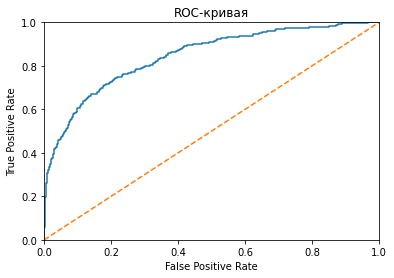

In [49]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid) 

plt.figure()

plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

* **RandomForestClassifier, Downsampling of majority class**

In [50]:
model = RandomForestClassifier(n_estimators=400, random_state=12345, max_depth = 10) 
model.fit(features_downsampled, target_downsampled) 
result = f1_score(target_test, model.predict(features_test)) 
probabilities_valid = model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_valid)

print("f1 на тестовой выборке:", result)
print("Значение AUC_ROC", auc_roc)

f1 на тестовой выборке: 0.5744274809160306
Значение AUC_ROC 0.8448232516029126


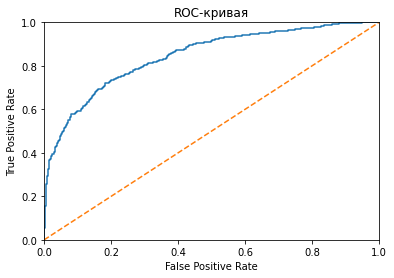

In [51]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid) 

plt.figure()

plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

* **RandomForestClassifier, Изменение порога классификации**

In [52]:
model = RandomForestClassifier(n_estimators=400, random_state=12345, max_depth = 10)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0.2, 0.5, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_test, predicted_valid)
    recall = recall_score(target_test, predicted_valid)
    f1 = f1_score(target_test, predicted_valid)
    print("Порог = {:.2f} | f1 = {:.3f}".format(threshold, f1)) 

Порог = 0.20 | f1 = 0.581
Порог = 0.22 | f1 = 0.585
Порог = 0.24 | f1 = 0.596
Порог = 0.26 | f1 = 0.602
Порог = 0.28 | f1 = 0.609
Порог = 0.30 | f1 = 0.620
Порог = 0.32 | f1 = 0.608
Порог = 0.34 | f1 = 0.607
Порог = 0.36 | f1 = 0.601
Порог = 0.38 | f1 = 0.595
Порог = 0.40 | f1 = 0.590
Порог = 0.42 | f1 = 0.566
Порог = 0.44 | f1 = 0.557
Порог = 0.46 | f1 = 0.556
Порог = 0.48 | f1 = 0.548


**Использованные в работе методы для балансировки классов наибольшее влияние оказали на модель Логистической регрессии. По сравнению с несбалансированными данными значение метрики f1  удалось увеличить на 0.19 (за счет использования class_weight и за счет изменения порога классификации), на 0.18 за счет увеличения количества данных минорного класса и на 0.17 за счет уменьшения данных мажоритарного класса. Решающие деревья и Случайный лес оказались менее чувствительны к дисбалансу классов. За счет примененных методов значение метрики f1 для DecisionTreeClassifier не изенилось или незначительно уменьшилось. Наибольшее качество для исследуемого датасета дала модель RandomForestClassifier при снижении порога классификации до 0.4 = f1 = 0.63 для валидационной выборки. Наилучшим значением на тестовой выборке стало f1 = 0.602 при использовании метода Upsampling of minority class.** 